In [1]:
import matplotlib.pyplot as plt
from numpy import *
from scipy import interpolate
from copy import copy, deepcopy

In [2]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [3]:
class readfield:
    def __init__(self, filename):
        D_file = open(filename, 'r', encoding = 'utf8')
        n = -1
        m = 0
        Dtemp = []
        for line in D_file:
            split_line = line.split();
            if is_number(split_line[0]):
                Dtemp[n].append([])
                Dtemp[n][m].extend([float(position) for position in split_line])
                m = m + 1
            else:
                Dtemp.append([])
                n = n + 1
                m = 0
        D_file.close()
        Dtemp = Dtemp[1]
        
        self.X = reshape([Dtemp[i][0] for i in range(len(Dtemp))],(81,81))*1e-3
        self.Y = reshape([Dtemp[i][1] for i in range(len(Dtemp))],(81,81))*1e-3
        self.Z = Dtemp[0][2]*1e-3
        self.N = int(sqrt(len(Dtemp)))
        self.DX = reshape([Dtemp[i][3] for i in range(len(Dtemp))],(81,81)) + 1j*reshape([Dtemp[i][4] for i in range(len(Dtemp))],(81,81))
        self.DY = reshape([Dtemp[i][5] for i in range(len(Dtemp))],(81,81)) + 1j*reshape([Dtemp[i][6] for i in range(len(Dtemp))],(81,81))
        self.DZ = reshape([Dtemp[i][7] for i in range(len(Dtemp))],(81,81)) + 1j*reshape([Dtemp[i][8] for i in range(len(Dtemp))],(81,81))
        self.D = swapaxes(stack([self.DX, self.DY, self.DZ],axis=1),1,2)
    def __copy__(self):
        return type(self)

In [4]:
class readarray:
    def __init__(self,filenameX1,filenameX2,filenameX3,filenameY1,filenameY2,filenameY3):
        ### X pol
        try:
            D_file = open(filenameX1, 'r', encoding = 'utf8')
            Dtemp = []
            for line in D_file:
                split_line = line.split();
                if is_number(split_line[0]) and float(split_line[0]) == 30.01:
                    Dtemp.append([float(position) for position in split_line])
            D_file.close()
            D_file = open(filenameX2, 'r', encoding = 'utf8')
            for line in D_file:
                split_line = line.split();
                if is_number(split_line[0]) and float(split_line[0]) == 30.01:
                    Dtemp.append([float(position) for position in split_line])
            D_file.close()
            D_file = open(filenameX3, 'r', encoding = 'utf8')
            for line in D_file:
                split_line = line.split();
                if is_number(split_line[0]) and float(split_line[0]) == 30.01:
                    Dtemp.append([float(position) for position in split_line])
            D_file.close()
            self.DX = reshape([Dtemp[i][1] + 1j*Dtemp[i][2] for i in range(len(Dtemp))],(8,8))
        except OSError:
            print('No X field')
            self.DX = zeros((8,8))
        ### Y pol
        try:
            D_file = open(filenameY1, 'r', encoding = 'utf8')
            Dtemp = []
            for line in D_file:
                split_line = line.split();
                if is_number(split_line[0]) and float(split_line[0]) == 30.01:
                    Dtemp.append([float(position) for position in split_line])
            D_file.close()
            D_file = open(filenameY2, 'r', encoding = 'utf8')
            for line in D_file:
                split_line = line.split();
                if is_number(split_line[0]) and float(split_line[0]) == 30.01:
                    Dtemp.append([float(position) for position in split_line])
            D_file.close()
            D_file = open(filenameY3, 'r', encoding = 'utf8')
            for line in D_file:
                split_line = line.split();
                if is_number(split_line[0]) and float(split_line[0]) == 30.01:
                    Dtemp.append([float(position) for position in split_line])
            D_file.close()
            self.DY = flip(reshape([Dtemp[i][1] + 1j*Dtemp[i][2] for i in range(len(Dtemp))],(8,8)),axis = 1).T
        except OSError:
            print('No Y field')
            self.DY = zeros((8,8))
        self.X, self.Y = meshgrid(linspace(0, 35*1e-3, num=8), linspace(0, 35*1e-3, num=8))
        self.Z = 2*1e-3
        self.N = 8
        self.DZ = zeros((8,8))
        self.D = swapaxes(stack([self.DX, self.DY, self.DZ],axis=1),1,2)

In [5]:
class combinearray:
    def __init__(self, array1, array2, array3, array4):
        self.DX = zeros((16,16)) + 1j*zeros((16,16))
        self.DX[0:-1:2,0:-1:2] = array1.DX
        self.DX[1:17:2,0:-1:2] = array2.DX
        self.DX[0:-1:2,1:17:2] = array3.DX
        self.DX[1:17:2,1:17:2] = array4.DX
        
        self.DY = zeros((16,16)) + 1j*zeros((16,16))
        self.DY[0:-1:2,0:-1:2] = array1.DY
        self.DY[1:17:2,0:-1:2] = array2.DY
        self.DY[0:-1:2,1:17:2] = array3.DY
        self.DY[1:17:2,1:17:2] = array4.DY
        
        self.DZ = zeros((16,16)) + 1j*zeros((16,16))
        self.DZ[0:-1:2,0:-1:2] = array1.DZ
        self.DZ[1:17:2,0:-1:2] = array2.DZ
        self.DZ[0:-1:2,1:17:2] = array3.DZ
        self.DZ[1:17:2,1:17:2] = array4.DZ
        
        self.X, self.Y = meshgrid(linspace(0, 37.5*1e-3, num=16), linspace(0, 37.5*1e-3, num=16))
        self.Z = 2*1e-3
        self.N = 16
        self.D = swapaxes(stack([self.DX, self.DY, self.DZ],axis=1),1,2)

# Loading data

In [6]:
Eanal = readfield('E.txt')
Hanal = readfield('H.txt')
Hanal.DX.shape

(81, 81)

In [7]:
arr = readarray('multiscan/arrayX.txt','multiscan/arrayX2.txt','multiscan/arrayX3.txt','multiscan/arrayY.txt','multiscan/arrayY2.txt','multiscan/arrayY3.txt')
arr_25x = readarray('multiscan/arrayX1_25x.txt','multiscan/arrayX2_25x.txt','multiscan/arrayX3_25x.txt','multiscan/arrayY1_25x.txt','multiscan/arrayY2_25x.txt','multiscan/arrayY3_25x.txt')
arr_25y = readarray('multiscan/arrayX1_25y.txt','multiscan/arrayX2_25y.txt','multiscan/arrayX3_25y.txt','multiscan/arrayY1_25y.txt','multiscan/arrayY2_25y.txt','multiscan/arrayY3_25y.txt')
arr_25x25y = readarray('multiscan/arrayX1_25x25y.txt','multiscan/arrayX2_25x25y.txt','multiscan/arrayX3_25x25y.txt','multiscan/arrayY1_25x25y.txt','multiscan/arrayY2_25x25y.txt','multiscan/arrayY3_25x25y.txt')
arr.DX.shape

(8, 8)

In [8]:
arr_16 = combinearray(arr, arr_25x, arr_25y, arr_25x25y)

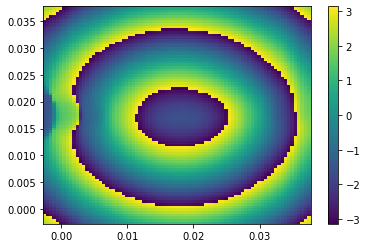

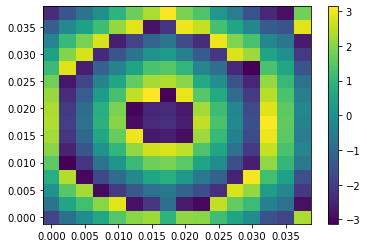

In [49]:
plt.pcolormesh(Eanal.X,Eanal.Y,angle(Eanal.DX),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr_16.X,arr_16.Y,angle(arr_16.DX*exp(1j*3)),shading='auto')
plt.colorbar()
plt.show()

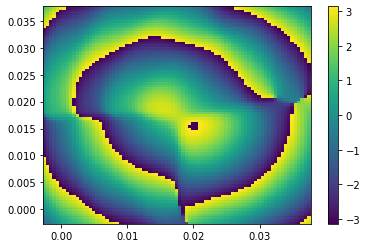

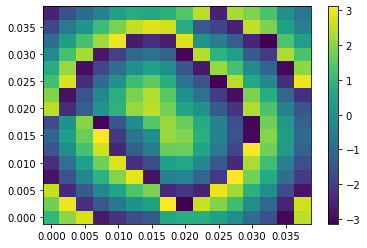

In [50]:
plt.pcolormesh(Eanal.X,Eanal.Y,angle(Eanal.DY),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr_16.X,arr_16.Y,angle(arr_16.DY*exp(1j*3)),shading='auto')
plt.colorbar()
plt.show()

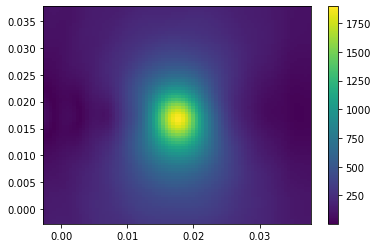

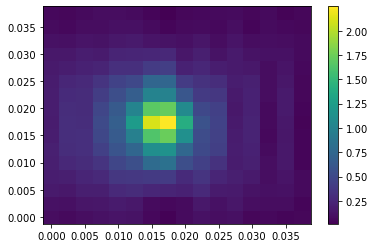

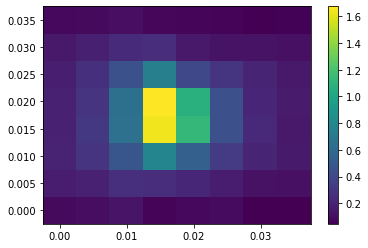

In [51]:
plt.pcolormesh(Eanal.X,Eanal.Y,abs(Eanal.DX),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr_16.X,arr_16.Y,abs(arr_16.DX),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr.X,arr.Y,abs(arr.DX),shading='auto')
plt.colorbar()
plt.show()

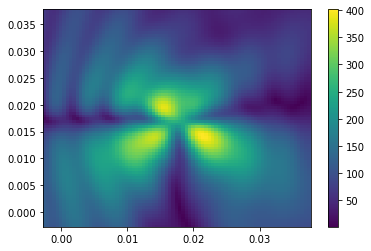

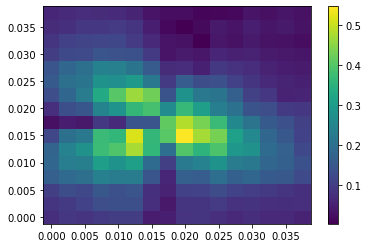

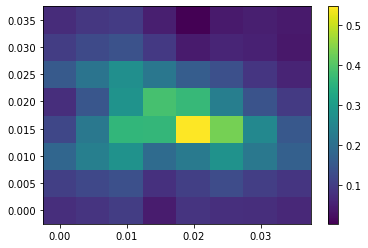

In [52]:
plt.pcolormesh(Eanal.X,Eanal.Y,abs(Eanal.DY),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr_16.X,arr_16.Y,abs(arr_16.DY),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr.X,arr.Y,abs(arr.DY),shading='auto')
plt.colorbar()
plt.show()

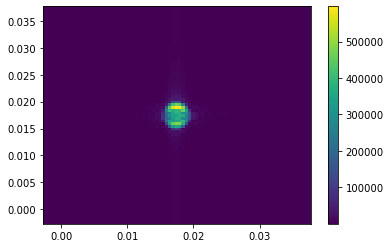

In [14]:
plt.pcolormesh(Eanal.X,Eanal.Y,abs(fft.fftshift(fft.fft2(fft.ifftshift(Eanal.DX)))),shading='auto')
plt.colorbar()
plt.show()

In [15]:
T = reshape([i for i in range(64)],(8,8))
T

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

### Rotate counter clockwise

In [16]:
flip(T,axis = 1).T

array([[ 7, 15, 23, 31, 39, 47, 55, 63],
       [ 6, 14, 22, 30, 38, 46, 54, 62],
       [ 5, 13, 21, 29, 37, 45, 53, 61],
       [ 4, 12, 20, 28, 36, 44, 52, 60],
       [ 3, 11, 19, 27, 35, 43, 51, 59],
       [ 2, 10, 18, 26, 34, 42, 50, 58],
       [ 1,  9, 17, 25, 33, 41, 49, 57],
       [ 0,  8, 16, 24, 32, 40, 48, 56]])

### Rotate clockwise

In [17]:
flip(T,axis = 0).T

array([[56, 48, 40, 32, 24, 16,  8,  0],
       [57, 49, 41, 33, 25, 17,  9,  1],
       [58, 50, 42, 34, 26, 18, 10,  2],
       [59, 51, 43, 35, 27, 19, 11,  3],
       [60, 52, 44, 36, 28, 20, 12,  4],
       [61, 53, 45, 37, 29, 21, 13,  5],
       [62, 54, 46, 38, 30, 22, 14,  6],
       [63, 55, 47, 39, 31, 23, 15,  7]])

f = interpolate.interp2d(Eanal.X[0], Eanal.X[0]+0.5, Eanal.DY, kind='cubic')

Einterp = f(arr.X[0],arr.X[0])

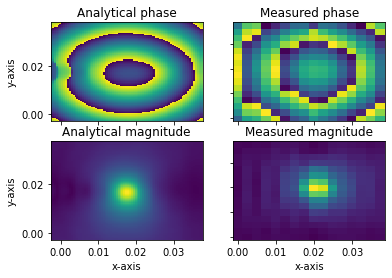

In [18]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].pcolormesh(Eanal.X,Eanal.Y,angle(Eanal.DX),shading='auto')
axs[0, 0].set_title('Analytical phase')
axs[0, 1].pcolormesh(arr_16.X,arr_16.Y,flip(angle(arr_16.DX)),shading='auto')
axs[0, 1].set_title('Measured phase')
axs[1, 0].pcolormesh(Eanal.X,Eanal.Y,abs(Eanal.DX),shading='auto')
axs[1, 0].set_title('Analytical magnitude')
axs[1, 1].pcolormesh(arr_16.X,arr_16.Y,flip(abs(arr_16.DX)),shading='auto')
axs[1, 1].set_title('Measured magnitude')

for ax in axs.flat:
    ax.set(xlabel='x-axis', ylabel='y-axis')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Maxwell's equations check

In [19]:
k0 = 2*pi*3e10/299792458
k0

628.7535065855045

In [20]:
Nspec = Eanal.N
dx = 0.5e-3
dy = 0.5e-3
kx = (-1/2 + (arange(Nspec))/Nspec)*(2*pi/dx)
ky = (-1/2 + (arange(Nspec))/Nspec)*(2*pi/dy)
KX,KY = meshgrid(kx,ky)
KZ = conj(sqrt((k0**2-KX**2-KY**2)*(1+0j)))

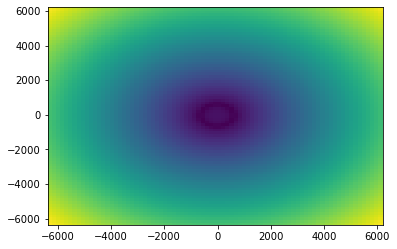

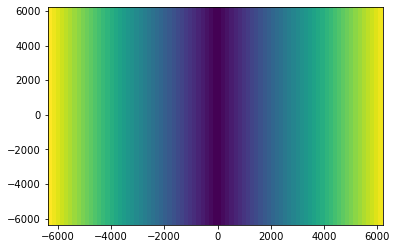

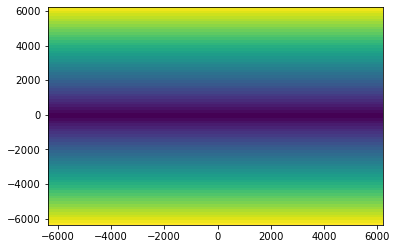

In [21]:
plt.pcolormesh(kx,ky,abs(KZ),shading='auto')
plt.show()
plt.pcolormesh(kx,ky,abs(KX),shading='auto')
plt.show()
plt.pcolormesh(kx,ky,abs(KY),shading='auto')
plt.show()

In [22]:
sEanal = copy(Eanal)
sEanal.X = KX
sEanal.Y = KY
sEanal.Z = KZ
sEanal.DX = fft.fftshift(fft.fft2(fft.ifftshift(Eanal.DX)))
sEanal.DY = fft.fftshift(fft.fft2(fft.ifftshift(Eanal.DY)))
sEanal.DZ = fft.fftshift(fft.fft2(fft.ifftshift(Eanal.DZ)))
sEanal.D = swapaxes(stack([sEanal.DX, sEanal.DY, sEanal.DZ],axis=1),1,2)

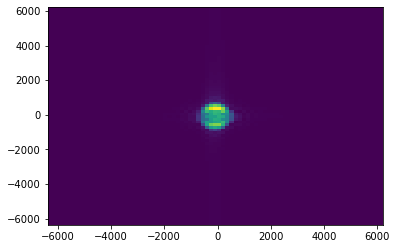

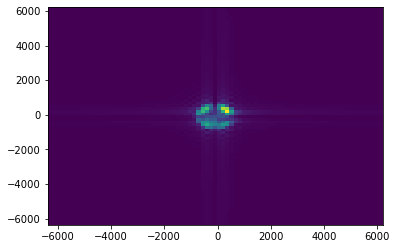

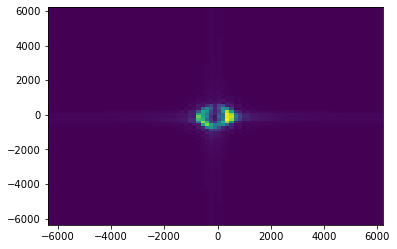

In [23]:
plt.pcolormesh(kx,ky,abs(sEanal.DX),shading='auto')
plt.show()
plt.pcolormesh(kx,ky,abs(sEanal.DY),shading='auto')
plt.show()
plt.pcolormesh(kx,ky,abs(sEanal.DZ),shading='auto')
plt.show()

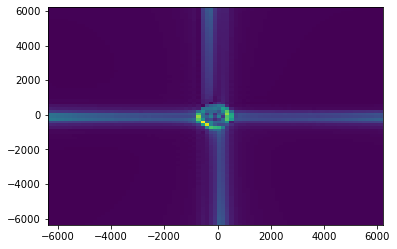

In [24]:
Gausse = sEanal.DX*KX + sEanal.DY*KY + sEanal.DZ*KZ
plt.pcolormesh(kx,ky,abs(Gausse),shading='auto')
plt.show()

In [25]:
abs(Gausse).max()

110351059.04003762

In [26]:
sEZ_rec = -(sEanal.DX*KX + sEanal.DY*KY)/KZ

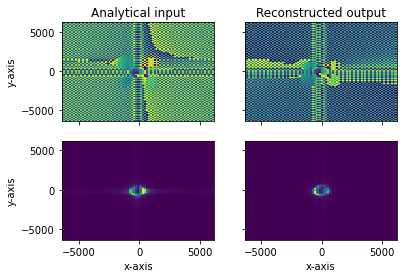

In [27]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].pcolormesh(sEanal.X,sEanal.Y,angle(sEanal.DZ),shading='auto')
axs[0, 0].set_title('Analytical input')
axs[0, 1].pcolormesh(sEanal.X,sEanal.Y,angle(sEZ_rec),shading='auto')
axs[0, 1].set_title('Reconstructed output')
axs[1, 0].pcolormesh(sEanal.X,sEanal.Y,abs(sEanal.DZ),shading='auto')
#axs[1, 0].set_title('Analytical magnitude')
axs[1, 1].pcolormesh(sEanal.X,sEanal.Y,abs(sEZ_rec),shading='auto')
#axs[1, 1].set_title('Rec. magnitude')

for ax in axs.flat:
    ax.set(xlabel='x-axis', ylabel='y-axis')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

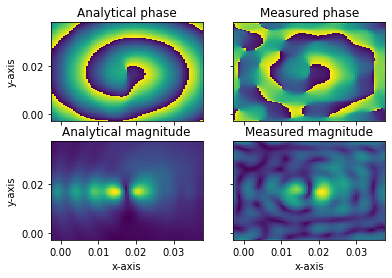

In [28]:
EZ_rec = fft.fftshift(fft.ifft2(fft.ifftshift(sEZ_rec)))

fig, axs = plt.subplots(2, 2)
axs[0, 0].pcolormesh(Eanal.X,Eanal.Y,angle(Eanal.DZ),shading='auto')
axs[0, 0].set_title('Analytical phase')
axs[0, 1].pcolormesh(Eanal.X,Eanal.Y,angle(EZ_rec),shading='auto')
axs[0, 1].set_title('Measured phase')
axs[1, 0].pcolormesh(Eanal.X,Eanal.Y,abs(Eanal.DZ),shading='auto')
axs[1, 0].set_title('Analytical magnitude')
axs[1, 1].pcolormesh(Eanal.X,Eanal.Y,abs(EZ_rec),shading='auto')
axs[1, 1].set_title('Measured magnitude')

for ax in axs.flat:
    ax.set(xlabel='x-axis', ylabel='y-axis')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [29]:
abs(EZ_rec)

array([[313.92892974, 369.66359492, 415.39864385, ..., 303.14739786,
        278.23349525, 272.66262374],
       [324.52702402, 319.82844009, 336.75818329, ..., 347.90354329,
        331.95824774, 334.03679211],
       [324.17136222, 326.81272792, 338.05003572, ..., 340.86006253,
        331.08189401, 329.98139463],
       ...,
       [185.0596474 , 182.30173872, 200.06599387, ..., 281.88218581,
        248.48628062, 209.30024943],
       [231.15843677, 232.38875974, 253.79695143, ..., 307.4781192 ,
        276.38920786, 245.65582644],
       [280.7274701 , 341.89471118, 388.97567785, ..., 292.17825267,
        265.86715367, 236.20354717]])

## Back-up codes

In [ ]:
plt.pcolormesh(arr_16.X,arr_16.Y,flip(angle(arr_16.DX*exp(1j*0.5)),axis = 1),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr_16.X,arr_16.Y,flip(angle(arr_16.DX*exp(1j*1)),axis = 1),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr_16.X,arr_16.Y,flip(angle(arr_16.DX*exp(1j*1.5)),axis = 1),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr_16.X,arr_16.Y,flip(angle(arr_16.DX*exp(1j*2)),axis = 1),shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(arr_16.X,arr_16.Y,flip(angle(arr_16.DX*exp(1j*2.5)),axis = 1),shading='auto')
plt.colorbar()
plt.show()